In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import warnings
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from sklearn.metrics import classification_report

In [3]:
# class 추가된 데이터 가져오기
df = pd.read_csv('./outputs/yt_clothes_class.csv', encoding='cp949')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,title,date,url,hashtag,class
0,"행복여 | 블록 레터링 루즈핏 봄 맨투맨 티셔츠 | 15,600원 | 라이브방송 |...",2022-03-21,https://www.youtube.com/shorts/jdIctLzCWxA,NaN,1
1,FALL LOOKBOOK / 03년생 / 모자추천 / 가을룩북 ㅇㅈㄹ,2021-09-21,https://www.youtube.com/watch?v=EOTGHHoRp2w,NaN,1
2,"존.예 겨울 원피스 하울~♥? 이쁘고 편한것만 골라와쏘?? (연말룩,하객룩,겨울코디)",2021-11-28,https://www.youtube.com/watch?v=DgZa_ttSqY8,#원피스하울 #겨울원피스 #겨울패션하울,1
3,가디건 이것만 알면 끝! - 가격대별 필수 가디건 추천 [코스/엘무드/일꼬르소/네이...,2022-03-17,https://www.youtube.com/watch?v=mpQEPl0qTiU,NaN,1
4,15분 초간단? 꾸안꾸 데일리 메이크업+스킨케어??,2022-02-05,https://www.youtube.com/watch?v=dNIHZPYP45A,#왕초보메이크업 #데일리메이크업 #화장잘먹는법,0


In [4]:
# 영향을 주지 않는 열 지우기
dff = df.drop(['date', 'url'], axis=1)

# 해시태그가 없는 열은 공백으로 채우기
dff = dff.fillna('')

# 종속변수, 독립변수 분리
dff_x = dff['title']
dff_y = dff['class']

## 데이터 불균형 처리

In [5]:
# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(dff_x, dff_y, test_size=0.3, random_state=25)

# 훈련 데이터 오버샘플링
oversample = RandomOverSampler(sampling_strategy='minority')

#샘플러에 들어가기 위해 array 타입으로 바꾸기
X_np_train = np.array(X_train) 
X_np_train = np.reshape(X_np_train, (len(X_train), 1))
y_np_train = np.array(y_train)

# resample
X_sample_train, y_sample_train = oversample.fit_resample(X_np_train, y_np_train)

# 다시 시리즈 형태로 만들어주기
X_list_train = X_sample_train.tolist() # type(X_list_train[0]) : list
X_train = []
for i in range(len(X_list_train)) :
    X_train.append(X_list_train[i][0])
X_train = pd.Series(X_train)
y_train = pd.Series(y_sample_train.tolist())

## 토큰화

In [6]:
okt = Okt()

def rmEmoji(inputData):

    emoji_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
            "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', inputData) # no emoji

#불용어 읽어오기
stopwords = pd.read_csv("stopwords.txt")
stopwords = stopwords['word'].tolist()

#불용어제거 + 토큰화
tk = []
for sentence in tqdm(X_train) :
    sentence = rmEmoji(sentence) # 이모티콘 제거
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tk.append(stopwords_removed_sentence)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tk)
word_dict = tokenizer.index_word

100%|██████████| 4048/4048 [00:10<00:00, 371.94it/s]


In [7]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(X_train_seq[:5])
print(X_train[:5])

for el in X_train_seq[0]:
    print(word_dict[el], end=' ')

[[1465, 18, 128, 32, 17, 115, 120, 190, 1914, 536], [], [1750, 3277, 2521, 17], [2522, 877, 273], [217, 33, 33, 27, 14, 30]]
0     30만원어치 미쏘 여름 신상 하울????트위드 자켓, 블라우스, 가디건, 탑 걱정 끝!
1                          여름시즌 입기좋은 린넨재킷, 쿨피즈룩, 66사이즈
2                                    애솔 - 말렌 셀린 바시티 자켓
3                                       데니아 탄탄 스판 스키니진
4    올 가을 유행은 가죽이라고 /가을 겨울 코디/ 옷 잘입는법여자/ 가죽자켓을 이용한 ...
dtype: object
미쏘 여름 신상 하울 자켓 블라우스 가디건 탑 걱정 끝 

In [8]:
# pad를 일정한 길이로 맞춰줌
X_train_pad = pad_sequences(X_train_seq, maxlen=40, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=40, padding='post')
X_train_pad[:5]
X_train_pad.shape

(4048, 40)

## Dense 다층 퍼셉트론

In [10]:
# Hyper Parameters
max_len = max(len(word) for word in tk)
vocab_size = len(word_dict)+1
embeding_dim = 16
drop_value = 0.2

# Model Architecture for dense network
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 54, 16)            105360    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 105,793
Trainable params: 105,793
Non-trainable params: 0
_________________________________________________________________


In [11]:
warnings.filterwarnings('ignore')

# Compiling the dense model
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

num_epochs = 10
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

history = model.fit(X_train_pad, y_train,
                    epochs = num_epochs, validation_data = (X_test_pad, y_test),
                    callbacks = [early_stop], verbose = 2)

Epoch 1/10
127/127 - 1s - loss: 0.6906 - accuracy: 0.5529 - val_loss: 0.6839 - val_accuracy: 0.7760
Epoch 2/10
127/127 - 0s - loss: 0.6543 - accuracy: 0.8174 - val_loss: 0.6150 - val_accuracy: 0.7760
Epoch 3/10
127/127 - 0s - loss: 0.5052 - accuracy: 0.8767 - val_loss: 0.4003 - val_accuracy: 0.9156
Epoch 4/10
127/127 - 0s - loss: 0.3280 - accuracy: 0.9150 - val_loss: 0.3360 - val_accuracy: 0.8510
Epoch 5/10
127/127 - 0s - loss: 0.2291 - accuracy: 0.9308 - val_loss: 0.2941 - val_accuracy: 0.8531
Epoch 6/10
127/127 - 0s - loss: 0.1725 - accuracy: 0.9491 - val_loss: 0.2803 - val_accuracy: 0.8521
Epoch 7/10
127/127 - 0s - loss: 0.1419 - accuracy: 0.9531 - val_loss: 0.2537 - val_accuracy: 0.8635
Epoch 8/10
127/127 - 0s - loss: 0.1176 - accuracy: 0.9597 - val_loss: 0.2328 - val_accuracy: 0.9135
Epoch 9/10
127/127 - 0s - loss: 0.1023 - accuracy: 0.9595 - val_loss: 0.2095 - val_accuracy: 0.9198
Epoch 10/10
127/127 - 0s - loss: 0.0899 - accuracy: 0.9644 - val_loss: 0.2363 - val_accuracy: 0.9094

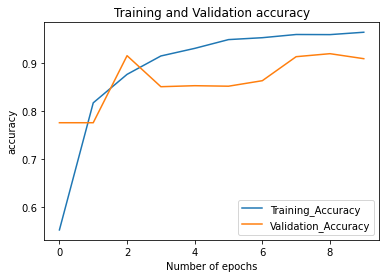

In [12]:
# Read the metrics as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column for plotting
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
  """
  plots the graph of var1, var2 vs number of epochs 
  """
  metrics[[var1, var2]].plot()
  plt.title('Training and Validation ' + string)
  plt.xlabel ('Number of epochs')
  plt.ylabel(string)
  plt.legend([var1, var2])

plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [13]:
# Predict(예측) 실행
y_predict = model.predict(X_test_pad)

y_predict2=[]
for i in range(len(y_predict)) :
    y_predict2.append(y_predict[i][0])
y_predict2 = pd.Series(y_predict2)
y_pred = y_predict2.apply(lambda x : 1 if x>=0.5 else 0)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      0.37      0.38        73
           1       0.95      0.95      0.95       887

    accuracy                           0.91       960
   macro avg       0.67      0.66      0.67       960
weighted avg       0.91      0.91      0.91       960



## LSTM

In [14]:
# LSTM hyperparameters
n_lstm = 10
drop_lstm = 0.2

# LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

# Compiling the LSTM Model
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Training and evaluating the LSTM Model
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(X_train_pad, y_train,
                     epochs=num_epochs, validation_data=(X_test_pad, y_test),
                     callbacks =[early_stop], verbose=2)

Epoch 1/10
127/127 - 9s - loss: 0.6007 - accuracy: 0.6962 - val_loss: 0.2956 - val_accuracy: 0.9177
Epoch 2/10
127/127 - 4s - loss: 0.2576 - accuracy: 0.9368 - val_loss: 0.2867 - val_accuracy: 0.9209
Epoch 3/10
127/127 - 3s - loss: 0.1813 - accuracy: 0.9610 - val_loss: 0.4427 - val_accuracy: 0.8689
Epoch 4/10
127/127 - 2s - loss: 0.1613 - accuracy: 0.9646 - val_loss: 0.3072 - val_accuracy: 0.9164


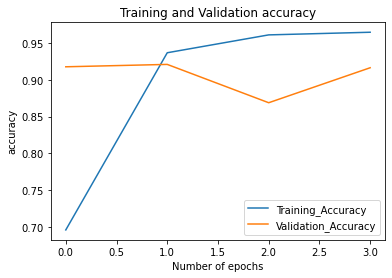

In [15]:
# Create a dataframe of metrics
metrics = pd.DataFrame(history.history)
# Rename columns for plotting
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')


In [16]:
# Predict(예측) 실행
y_predict = model1.predict(X_test_pad)

y_predict2=[]
for i in range(len(y_predict)) :
    y_predict2.append(y_predict[i][0])
y_predict2 = pd.Series(y_predict2)
y_pred = y_predict2.apply(lambda x : 1 if x>=0.5 else 0)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.18      0.63      0.28        73
           1       0.96      0.77      0.85       887

    accuracy                           0.76       960
   macro avg       0.57      0.70      0.57       960
weighted avg       0.90      0.76      0.81       960



## BiLSTM

In [17]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

# Compiling the Bi-LSTM Model
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# Training and evaluating the Bi-LSTM model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(X_train_pad, y_train, epochs=num_epochs, 
                    validation_data=(X_test_pad, y_test), 
                    callbacks =[early_stop], verbose=2)


Epoch 1/30
127/127 - 7s - loss: 0.6474 - accuracy: 0.6602 - val_loss: 0.4353 - val_accuracy: 0.8372
Epoch 2/30
127/127 - 2s - loss: 0.2886 - accuracy: 0.9342 - val_loss: 0.3803 - val_accuracy: 0.8501
Epoch 3/30
127/127 - 2s - loss: 0.1745 - accuracy: 0.9603 - val_loss: 0.3578 - val_accuracy: 0.8718
Epoch 4/30
127/127 - 2s - loss: 0.1492 - accuracy: 0.9653 - val_loss: 0.4100 - val_accuracy: 0.8656
Epoch 5/30
127/127 - 2s - loss: 0.1406 - accuracy: 0.9660 - val_loss: 0.3106 - val_accuracy: 0.9055
Epoch 6/30
127/127 - 2s - loss: 0.1256 - accuracy: 0.9697 - val_loss: 0.4286 - val_accuracy: 0.8640
Epoch 7/30
127/127 - 2s - loss: 0.1204 - accuracy: 0.9726 - val_loss: 0.2911 - val_accuracy: 0.9293
Epoch 8/30
127/127 - 2s - loss: 0.1603 - accuracy: 0.9589 - val_loss: 0.2990 - val_accuracy: 0.9141
Epoch 9/30
127/127 - 2s - loss: 0.1317 - accuracy: 0.9641 - val_loss: 0.3032 - val_accuracy: 0.9171


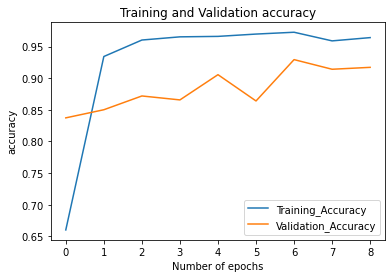

In [18]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [19]:
# Predict(예측) 실행
y_predict = model2.predict(X_test_pad)

y_predict2=[]
for i in range(len(y_predict)) :
    y_predict2.append(y_predict[i][0])
y_predict2 = pd.Series(y_predict2)
y_pred = y_predict2.apply(lambda x : 1 if x>=0.5 else 0)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.27      0.60      0.38        73
           1       0.96      0.87      0.91       887

    accuracy                           0.85       960
   macro avg       0.62      0.74      0.64       960
weighted avg       0.91      0.85      0.87       960

